# Multi-Agent Simulations of (Argumentative) Belief Dynamics with LMs

## General settings

In [16]:
import pandas as pd
import numpy as np

In [391]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import logging
from IPython.display import display, HTML

from nltk import ngrams

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [392]:
!nvidia-smi

Tue Mar  9 16:54:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:B2:00.0 Off |                    0 |
| N/A   32C    P0    53W / 300W |  17825MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Topic 

In [393]:
topics = [
    {
        'id': 'compulsory_voting',
        'claims': {
            'connector': ' And therefore, all in all,',
            'pro': [' compulsory voting is a pretty good idea.', ' I am for compulsory voting.'],
            'con': [' compulsory voting is a really bad idea.', ' I am against compulsory voting.']
        },
        'intro': 'Let\'s discuss compulsory voting! Should citizens be free to abstain from voting? Or should voting be made compulsory?',
        'prompt': 'I more or less agree with what my peers are saying here. Regarding the idea of compulsory voting, I\'d just add the following thought:\n',
        'initial_posts': [
            { 
                'type':'pro',
                'text':'Turnout in British election is distressingly low. Compulsory voting might fix this problem and increase the legitimacy of our government.'
            },
            { 
                'type':'pro',
                'text':'Low participation rates are doubly dangerous. They mean our politicians are not representative of the population as a whole.'
            },
            { 
                'type':'pro',
                'text':'Since the poor and disadvantaged are far less likely to vote than any other group, they can safely be ignored by mainstream politicians. The only way to break this cycle is mandatory voting.'
            },
            { 
                'type':'pro',
                'text':'We compel people to wear seatbelts and to serve on juries and we should not be afraid to do the same in the case of voting.'
            },
            { 
                'type':'pro',
                'text':'Liberal democracy relies on a balance of rights. Lack of participation puts our current political system in a crisis, which requires us to restrict some personal rights and to make voting mandatory.'
            },
            { 
                'type':'pro',
                'text':'We owe it to our ancestors, who fought for the establishement of democratic government, to exercise our right to vote. If people are so apathetic they will not do see freely, we must make it mandatory.'
            },
            {
                'type':'pro',
                'text':'Voting is compulsory in other countries, for instance in Australia. We should adopt the same system to secure greater democratic involvement.'
            },
            {
                'type':'pro',
                'text':'Proxy voting and postal voting will be available for those who cannot physically get to the polling station – voting by the Internet could also be arranged for.'
            },
            { 
                'type':'con',
                'text':'There are many reasons why people do not vote. Up to 10 per cent of the population is not on the electoral register at any one time.'
            },
            { 
                'type':'con',
                'text':'The alleged crisis of democracy does not allow for infringing an individual\'s liberty, including the liberty to abstain from voting.'
            },
            { 
                'type':'con',
                'text':'Compulsory voting would create political prisoners and hardly help the democratic process.'
            },
            { 
                'type':'con',
                'text':'Refraining from the democratic process is a democratic statement of disenchantment. Those who are disenchanted with politics in general have a right to register their dissatisfaction.'
            },
            { 
                'type':'con',
                'text':'Peoples right to abstain from voting should not be taken away by politicians who want to hide the fact of their upopularity and irrelevance in society.'
            },
            { 
                'type':'con',
                'text':'Just as the right to free speech is complemented by the right to silence, so the right to vote is balanced by the right of abstention.'
            },
            {
                'type':'con',
                'text':'Many people cannot get away from their work, or find someone to look after their children. And that\'s the reason why they don\'t vote.',
            },
            {
                'type':'con',
                'text':'Some people who don\'t vote cannot get physically to the polling booth. Others are simply not interested in politics.'
            },
            {
                'type':'con',
                'text':'There are many reasons why people don\'t vote. None of these motivations can be affected by forcing people to vote – those who cannot will continue not to, and those who are not interested will vote randomly.'
            },
            {
                'type':'pro',
                'text':'In the 1998 local elections, turnout averaged no more than 30 per cent, and in some areas under 20 per cent. Even in the 1997 general election, almost 30 per cent of the population did not vote.'
            }
            
        ]
    }
]

### Model and Tokenizer

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
model = GPT2LMHeadModel.from_pretrained('gpt2-large')
model.to("cuda")
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

In [5]:
NEWLINE_TOKENID = tokenizer("I\n")['input_ids'][-1]
NEWLINE_TOKENID

198

In [6]:
EOS_TOKENIDS = [tokenizer(c)['input_ids'][0] for c in "!?."]
EOS_TOKENIDS

[0, 30, 13]

In [7]:
ETC_TOKENID = tokenizer("...")['input_ids'][-1]
ETC_TOKENID

986

In [8]:
tokenizer(" I")['input_ids'][-1]

314

In [9]:
XA0_TOKENID = tokenizer("A\xa0")['input_ids'][-1]
XA0_TOKENID

1849

In [10]:
tokenizer.eos_token_id

50256

### Global parameters 

In [403]:
global_parameters = {
    'topic':'compulsory_voting',
    'n_agents':10,
    'max_t':40,
    'n_initial_posts':2, # number of initial posts, simulaion starts at t = n_initial_posts 
    'context_size':15, # max number of posts that are included in an agents perspective
    'relevance_deprecation':.9, # how much more likely (factor) is it the agents retains a post dating from (t-k-1) than one dating from (t-k)
    'self_confidence':1, # how much more likely (factor) is it the agents retains a post from her own than from a peer 
    'n_gram_prohibition':5, # drop generated sentences as soon as n-gram of this size is repeated 
    'perspective_expansion_method':'random',
    'peer_selection_method':'bounded_confidence'
}

peer_selection_parameters = [
     {
         'id':'all_neighbors'
     },
     {
         'id':'bounded_confidence',
         'epsilon':0.002
     }
#    {
#        'id':'closed_rooms',
#        'by_roomsize': False, # Determine number of rooms by n_agents/agents_per_room
#        'n_rooms':2,
#        'agents_per_room':5
#    }
]



In [404]:
decoding_parameters = {
    'do_sample':True, 
    'num_beams':5,
    'temperature': 1, # 1.3,
    'top_p': 0.5, # 0.99, 
    'top_k':0,
     #'no_repeat_ngram_size':8,
    'repetition_penalty':1.2,
    'max_length':40,
    'bad_words_ids':[[NEWLINE_TOKENID],[ETC_TOKENID]]
}

## Define Conversation

In [405]:
class Conversation():
        
    def __init__(self, global_parameters:dict=None, topic:dict=None):
        self.topic = topic
        self.global_parameters = global_parameters
        
        # set up the dataframe
        columns = ['post','peers','perspective','tokens','polarity','salience']
        steps = np.arange(global_parameters['max_t'])
        agents = np.arange(global_parameters['n_agents'])
        steps_agents = [
           steps,
           agents
        ]
        index = pd.MultiIndex.from_product(steps_agents, names=["step", "agent"])
        self.data = pd.DataFrame(np.zeros((global_parameters['max_t']*global_parameters['n_agents'], len(columns))), index=index, columns=columns)
        self.data = self.data.astype(object)
        self.data['perspective']=[[] for i in range(len(self.data))]
        self.data['peers']=[[] for i in range(len(self.data))]
        self.data['tokens']=[[] for i in range(len(self.data))]
        

    def contribute(self, contribution=None, agent:int=0, t:int=0, col:str=None):
        self.data.loc[t,agent][col] = contribution

    def get(self, agent:int=0, t:int=0, col:str=None):
        return self.data.loc[t,agent][col]

    def submit_post(self, post=None, agent:int=0, t:int=0):
        self.contribute(contribution=post, agent=agent, t=t, col="post")
        
        

## Define Agents

In [406]:
class AbstractLMAgent:
    """Interface for different LM agents"""
    
    def initialize(self, initial_steps:int=2):
        pass
        
    def update_peers(self, t: int):
        pass

    def update_perspective(self, t: int):
        pass

    def make_contribution(self, t: int):
        pass

    def update_opinion(self, t: int):
        pass



In [407]:
class LMUtilitiesMixIn:

    def conditional_loss(self, labels, logits, k_last_tokens):
        # Shift so that logits at index n predict token n in labels
        shift_logits = logits[..., :-1, :].contiguous() # drop last token
        shift_labels = labels[..., 1:].contiguous() # drop first token; this effectively causes the shift

        # Only keep last k_last_tokens tokens
        shift_logits = shift_logits[..., -k_last_tokens:, :].contiguous()
        shift_labels = shift_labels[..., -k_last_tokens:].contiguous() 

        # use CrossEntropy loss function
        loss_fct = torch.nn.CrossEntropyLoss()
        last_k_loss = loss_fct(
        # Flatten the tokens, i.e. reduce dimension
        shift_logits.view(-1, shift_logits.size(-1)), 
        shift_labels.view(-1)
        ) 

        return last_k_loss 
    
    def post_process(self, tokenids):
        """post-process generated post (tokens)"""
        processed = tokenids

        # remove quotation marks 
        processed = [t for t in processed if t not in tokenizer("\"")['input_ids']]
        processed = [t if t not in tokenizer(".\"")['input_ids'] else tokenizer(".")['input_ids'][-1] for t in processed]
        # remove etc.
        processed = [t for t in processed if not t==ETC_TOKENID]

        # discard everything after tokenizer.eos_token_id
        if self.tokenizer.eos_token_id in processed:
            eos_id = processed.index(self.tokenizer.eos_token_id)
            processed = processed[:eos_id]

        # post-process sentences
        eos_idx = [i for i,token in enumerate(processed) if token in EOS_TOKENIDS]   
        if len(eos_idx)>0:
            # drop last, incomplete sentence
            processed = processed[:(eos_idx[-1]+1)]

            # drop first sentence that repeats n-gram and following ones
            def repeats_ngram(start,stop):
                grams = list(ngrams(processed[start:stop], self.conversation.global_parameters['n_gram_prohibition']))
                grams_before = list(ngrams(processed[:start], self.conversation.global_parameters['n_gram_prohibition']))
                repeats = any(g in grams_before for g in grams)
                return repeats

            drop_later = [start for start,stop in zip(eos_idx[:-1],eos_idx[1:]) if repeats_ngram(start,stop)]
            if len(drop_later)>0:
                processed = processed[:(drop_later[0]+1)]
        else:
            processed = processed + [ETC_TOKENID]

        return processed

In [408]:
class LMAgent(AbstractLMAgent,LMUtilitiesMixIn):
    def __init__(self, 
                 model: GPT2LMHeadModel = None, 
                 tokenizer: GPT2Tokenizer = None, 
                 conversation: Conversation = None,
                 neighbors:[int] = [],
                 agent:int = 0,
                 peer_selection_args:dict = None,
                 decoding_args:dict = None
                ):
        self.model = model
        self.tokenizer = tokenizer   
        self.conversation = conversation
        self.neighbors = neighbors
        self.agent = agent
        self.peer_selection_args = peer_selection_args 
        self.decoding_args = decoding_args
        

        
    # initialize the conversation
    def initialize(self, initial_steps:int=2):
        # initialize peers
        # in the initialization phase, all neighbours are peers
        for t in range(initial_steps):
            self.conversation.contribute(
                contribution=self.neighbors,
                t=t,
                agent=self.agent,
                col="peers"
            )
        
        # initialize perspective
        for t in range(1,initial_steps):
            perspective = [(i,j) for i in range(t) for j in self.neighbors]
            if len(perspective)>self.conversation.global_parameters.get('context_size'):
                perspective = random.sample(perspective,k=self.conversation.global_parameters.get('context_size'))
            self.conversation.contribute(
                contribution=perspective,
                t=t,
                agent=self.agent,
                col="perspective"
            )
        
        # initialize posts from topic
        for t in range(initial_steps):
            ## pro / con split in groups
            #pros = [p for p in topic['initial_posts'] if p['type']=='pro']
            #cons = [p for p in topic['initial_posts'] if p['type']=='con']
            #df.loc[t]['post'] = df.loc[t]['peers'].apply(lambda peers: random.choice(pros) if (0 in peers) else random.choice(cons)) 
            #df.loc[t]['tokens'] = df.loc[t]['post'].apply(lambda p: tokenizer(p['text'])['input_ids'])
            post = random.choice(self.conversation.topic['initial_posts'])
            self.conversation.submit_post(
                post=post,
                t=t,
                agent=self.agent
            )
            self.conversation.contribute(
                contribution=self.tokenizer(post['text'])['input_ids'],
                t=t,
                agent=self.agent,
                col="tokens"
            )
            
        # initialize opinions
        for t in range(initial_steps):
            self.update_opinion(t)
                    
        
    def update_peers(self, t: int):
        if self.peer_selection_args.get('id')=='all_neighbors':
            self.conversation.contribute(
                contribution=self.neighbors,
                t=t,
                agent=self.agent,
                col="peers"
            )
        elif self.peer_selection_args.get('id')=='bounded_confidence':
            epsilon = self.peer_selection_args.get('epsilon')
            opinion = lambda i: self.conversation.get(agent=i, t=t-1, col='polarity')
            peers = [i for i in self.neighbors if abs(opinion(i)-opinion(self.agent))<epsilon]
            self.conversation.contribute(
                contribution=peers,
                t=t,
                agent=self.agent,
                col="peers"
            )
        else:
            print('Unknown peer selection method! No peers selected.')

            
    def update_perspective(self, t: int):
        # 1. get previous perspective
        perspective = self.conversation.get(agent=self.agent, t=t-1, col='perspective')

        # 2. forget some former posts
        perspective = self.concat_persp(perspective, t=t)
        
        # 3. fill-in missing gaps
        perspective = self.expand_persp(perspective, t=t)
        
        # 4. update
        self.conversation.contribute(
            contribution=perspective,
            t=t,
            agent=self.agent,
            col="perspective"
        )
        

    def concat_persp(self, perspective, t:int=0):
        perspective = perspective
        dep_exp = self.conversation.global_parameters.get('relevance_deprecation')
        sc_fact = self.conversation.global_parameters.get('self_confidence')
        
        weight = lambda tt,i: dep_exp**(t-tt-1) * (sc_fact if i==self.agent else 1)
        weights = [weight(tt,i) for tt,i in perspective] 

        new_perspective = []
        for p,w in zip(perspective,weights):
            if random.uniform(0,1)<w:
                new_perspective.append(p)

        return new_perspective


    
    def expand_persp(self, perspective, t:int=0):
        perspective = perspective
        size = self.conversation.global_parameters.get('context_size')
        peers = self.conversation.get(
                t=t,
                agent=self.agent,
                col="peers"
            )
        peer_posts = [(t-1,i) for i in peers]

        # append all peer posts if max perspective size allows 
        if len(peer_posts)+len(perspective) <= size:
            return peer_posts + perspective

        # determine weights for selecting new posts for perspective according to perspective_expansion_method
        if self.conversation.global_parameters.get('perspective_expansion_method')=='random':
            # uniform weights
            weights = [1]*len(peer_posts)
        if self.conversation.global_parameters.get('perspective_expansion_method')=='confirmation_bias':
            # weights reflect relevance confirmation of current normalized belief by post
            def conf(p:(int)):
                x0 = self.conversation.get(t=0,agent=self.agent,col="polarity")
                opinion = self.elicit_opinion
                c = (opinion(perspective+[p])-x0)/(opinion(perspective)-x0)
                c = 0 if c<0 else c
                return c                
            weights = [conf(p) for p in peer_posts]
            # are some weights >0? if not, use uniform positive weights
            if all(w==0 for w in weights):
                weights = [1]*len(peer_posts)
        else:
            print('Unknown perspective_expansion_method, using uniform weights')
            weights = [1]*len(peer_posts)

        peer_posts = random.choices(peer_posts, k=(size-len(perspective)), weights=weights)
                
        return peer_posts + perspective

    
    
    def make_contribution(self, t: int):
        perspective = self.conversation.get(agent=self.agent, t=t, col='perspective')        
        
        # collect_and_glue_perspective_tokens
        tokens = self.conversation.topic['intro_tokens']
        tokens = tokens + [NEWLINE_TOKENID]
        for tt,i in perspective:
            tokens = tokens + self.conversation.get(agent=i, t=tt, col='tokens')
            tokens = tokens + [NEWLINE_TOKENID]
        tokens = tokens + topic['prompt_tokens']
        
        # adjust max length parameter
        params = self.decoding_args.copy()
        params['max_length'] = params['max_length']+len(tokens)
        
        # generate
        output = self.model.generate(
            torch.tensor([tokens]).to('cuda'),
            **params
        )
        
        gen_tokens = output.tolist()[0][len(tokens):] # drop input sequence
        gen_tokens = self.post_process(gen_tokens) # post-process
        
        # decode
        gen_text = {'text':self.tokenizer.decode(gen_tokens)}

        
        self.conversation.submit_post(post=gen_text, t=t, agent=self.agent)
        self.conversation.contribute(contribution=gen_tokens, t=t, agent=self.agent, col="tokens")        
        
        

        
    def update_opinion(self, t: int):
        perspective = self.conversation.get(agent=self.agent, t=t, col='perspective')
        polarity, salience = self.elicit_opinion(perspective)            
        self.conversation.contribute(contribution=polarity, t=t, agent=self.agent, col="polarity")
        self.conversation.contribute(contribution=salience, t=t, agent=self.agent, col="salience")

        
        
    def elicit_opinion(self, perspective: [(int)]):
        
        # collect_and_glue_perspective_tokens
        token_ids_cond = self.conversation.topic['intro_tokens']
        for tt,i in perspective:
            token_ids_cond = token_ids_cond + self.conversation.get(agent=i, t=tt, col='tokens')
        token_ids_cond = token_ids_cond + self.conversation.topic['claim_tokens']['connector']

        # we account for multiple formulations of the pro-claim / the con-claim
        token_ids_pro = self.conversation.topic['claim_tokens']['pro'] # list of token lists
        token_ids_con = self.conversation.topic['claim_tokens']['con'] # list of token lists
        
        # average conditional perplexity pro claims
        PP_pro = 0
        for token_ids in token_ids_pro: 
            input_tensor = torch.tensor([token_ids_cond + token_ids]).to('cuda')
            output = self.model(input_tensor,labels=input_tensor)
            PP_pro = PP_pro + np.exp(self.conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())
        PP_pro = PP_pro / len(token_ids_pro)

            
        # average conditional perplexity con claims
        PP_con = 0
        for token_ids in token_ids_con: 
            input_tensor = torch.tensor([token_ids_cond + token_ids]).to('cuda')
            output = self.model(input_tensor,labels=input_tensor)
            PP_con = PP_con + np.exp(self.conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())
        PP_con = PP_con / len(token_ids_con)
        
        polarity = PP_pro/(PP_pro+PP_con)
        salience = (PP_pro+PP_con)/2.0
        
        return polarity, salience
        


### Initialization

In [409]:
topic = next(t for t in topics if t['id']==global_parameters['topic'])
topic['intro_tokens'] = tokenizer(topic['intro'])['input_ids']
topic['prompt_tokens'] = tokenizer(topic['prompt'])['input_ids']
topic['claim_tokens'] = {
    'connector': tokenizer(topic['claims']['connector'])['input_ids'],
    'pro':[tokenizer(t)['input_ids'] for t in topic['claims']['pro']], # list of token lists
    'con':[tokenizer(t)['input_ids'] for t in topic['claims']['con']] # list of token lists
}

conversation = Conversation(global_parameters=global_parameters,topic=topic)

agents = []
for i in range(global_parameters['n_agents']):
    agent = LMAgent(
        model=model, 
        tokenizer=tokenizer, 
        conversation=conversation, 
        neighbors=list(range(global_parameters['n_agents'])),
        peer_selection_args=next(args for args in peer_selection_parameters if args['id']==global_parameters['peer_selection_method']),
        decoding_args=decoding_parameters,
        agent=i
    )
    agents.append(agent)

for agent in agents:
    agent.initialize(initial_steps=2)

agents[1].conversation.data.loc[1]


,post,peers,perspective,tokens,polarity,salience
agent,,,,,,
0,"{'type': 'pro', 'text': 'Low participation rat...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","[20535, 10270, 3965, 389, 3385, 306, 4923, 13,...",0.483044,4.46912
1,"{'type': 'con', 'text': 'Refraining from the d...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","[8134, 24674, 422, 262, 10518, 1429, 318, 257,...",0.509607,7.30528
2,"{'type': 'pro', 'text': 'Low participation rat...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","[20535, 10270, 3965, 389, 3385, 306, 4923, 13,...",0.466198,4.49111
3,"{'type': 'con', 'text': 'Just as the right to ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","[5703, 355, 262, 826, 284, 1479, 4046, 318, 12...",0.469926,6.20535
4,"{'type': 'pro', 'text': 'Low participation rat...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","[20535, 10270, 3965, 389, 3385, 306, 4923, 13,...",0.485622,5.45931
5,"{'type': 'pro', 'text': 'Low participation rat...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","[20535, 10270, 3965, 389, 3385, 306, 4923, 13,...",0.487234,5.56447
6,"{'type': 'pro', 'text': 'We compel people to w...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","[1135, 33729, 661, 284, 5806, 5852, 6667, 912,...",0.495061,8.19397
7,"{'type': 'con', 'text': 'Some people who don't...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","[4366, 661, 508, 836, 470, 3015, 2314, 651, 10...",0.491969,7.21002
8,"{'type': 'con', 'text': 'Refraining from the d...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","[8134, 24674, 422, 262, 10518, 1429, 318, 257,...",0.576891,13.0922


### Loop

In [410]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    for agent in agents:
        # Determine peers
        agent.update_peers(t)

        # Determine perspective
        agent.update_perspective(t)

        # Generate posts
        agent.make_contribution(t)
        
        # Update opinion
        agent.update_opinion(t)

        

  0%|          | 0/38 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  3%|▎         | 1/38 [00:19<11:59, 19.45s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for o

Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 66%|██████▌   | 25/38 [07:24<04:12, 19.45s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 68%|██████▊   | 26/38 [07:44<03:56, 19.71s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 71%|███████   | 27/38 [08:04<03:38, 19.82s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 74%|███████▎  | 28/38 [08:25<03:19, 19.97s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 76%|███████▋  | 29/38 [08:44<02:59, 19.89s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 79%|███████▉  | 30/38 [09:04<02:39, 19.92s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 82%|████████▏ | 31/38 [09:25<02:21, 20.19s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 84%|████████▍ | 32/38 [09:46<02:01, 20.29s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 87%|████████▋ | 33/38 [10:06<01:42, 20.41s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 89%|████████▉ | 34/38 [10:27<01:21, 20.47s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 92%|█████████▏| 35/38 [10:48<01:01, 20.50s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 95%|█████████▍| 36/38 [11:08<00:41, 20.61s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 97%|█████████▋| 37/38 [11:29<00:20, 20.59s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Unknown perspective_expansion_method, using uniform weights


100%|██████████| 38/38 [11:49<00:00, 18.68s/it]


<AxesSubplot:xlabel='step'>

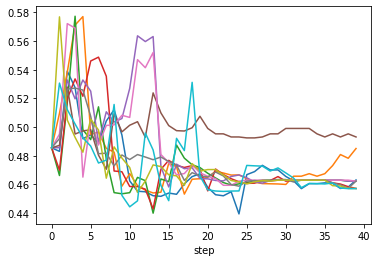

In [411]:
conversation.data.polarity.unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

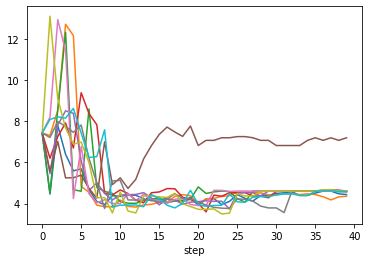

In [412]:
conversation.data.salience.unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

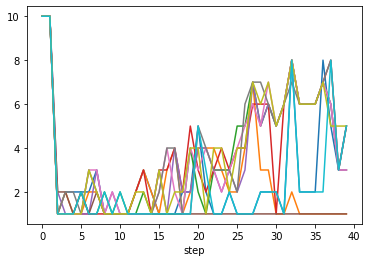

In [413]:
conversation.data.peers.apply(len).unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

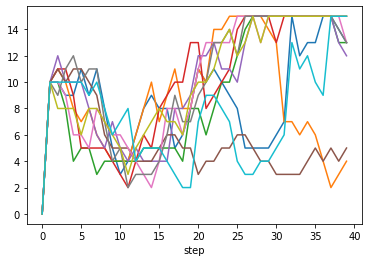

In [414]:
conversation.data.perspective.apply(len).unstack().plot(legend=False)

In [398]:
agents[0].peer_selection_args

{'id': 'bounded_confidence', 'epsilon': 0.002}

In [415]:
conversation.data.peers.unstack()

agent,0,1,2,3,4,5,6,7,8,9
step,,,,,,,,,,
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
2,[0],[1],[2],[3],"[4, 5]","[4, 5]",[6],[7],[8],[9]
3,"[0, 1]","[0, 1]",[2],[3],[4],"[5, 7]",[6],"[5, 7]",[8],[9]
4,"[0, 7]",[1],[2],[3],[4],[5],[6],"[0, 7]",[8],[9]
5,"[0, 9]",[1],"[2, 5]",[3],[4],"[2, 5]",[6],[7],[8],"[0, 9]"
6,"[0, 1]","[0, 1]",[2],[3],[4],[5],"[6, 7, 8]","[6, 7, 8]","[6, 7, 8]",[9]
7,"[0, 4, 6]","[1, 8]",[2],[3],"[0, 4, 6]","[5, 7]","[0, 4, 6]","[5, 7]","[1, 8]",[9]
8,[0],[1],"[2, 9]",[3],[4],[5],[6],[7],[8],"[2, 9]"


In [417]:
display_agents = [2,3,4,6,5]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = conversation.data.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

,agent 2,agent 3,agent 4,agent 6,agent 5
step,,,,,
0,"Voting is compulsory in other countries, for instance in Australia. We should adopt the same system to secure greater democratic involvement.",Proxy voting and postal voting will be available for those who cannot physically get to the polling station – voting by the Internet could also be arranged for.,"The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","Just as the right to free speech is complemented by the right to silence, so the right to vote is balanced by the right of abstention.",Peoples right to abstain from voting should not be taken away by politicians who want to hide the fact of their upopularity and irrelevance in society.
1,Low participation rates are doubly dangerous. They mean our politicians are not representative of the population as a whole.,"Just as the right to free speech is complemented by the right to silence, so the right to vote is balanced by the right of abstention.",Low participation rates are doubly dangerous. They mean our politicians are not representative of the population as a whole.,We compel people to wear seatbelts and to serve on juries and we should not be afraid to do the same in the case of voting.,Low participation rates are doubly dangerous. They mean our politicians are not representative of the population as a whole.
2,"If you're not interested in politics, why should you vote?","If you want to make voting compulsory, you should make it compulsory for everyone, not just those who can afford to pay for it.","If you don't like it, don't vote for it.","If you have a right to vote, you have a right to abstain from voting.","If you want to vote, you should be able to vote."
3,"If you're not interested in politics, why should you vote?","If you want to make voting compulsory, you should make it compulsory for everyone, not just those who can afford to pay for it.","If you don't like it, don't vote for it.","If we are going to go down the road of compulsory voting, let's make sure that it is not a one-way street.","If you want to vote, you should be able to vote."
4,"If you're not interested in politics, why should you vote?","It's a good idea to make voting compulsory for everyone, not just those who can afford to pay for it.",I'm not sure that compulsory voting is the best way to solve the problem of low participation rates.,"If you have a right to vote, you have a right to abstain from voting.","If we're going to make voting compulsory, we should make it compulsory for all citizens."
5,"If we're going to make voting compulsory, we should make it compulsory for all citizens.","If you want to make voting compulsory, you should make it compulsory for everyone, not just those who can afford to pay for it.",I more or less agree with what my peers are saying here.,"If we are going to go down the road of compulsory voting, let's make sure that it is not a one-way street.","If we are going to make voting compulsory, then we should make it compulsory for all citizens."
6,"If we're going to make voting compulsory, we should make it compulsory for all citizens.","It's a good idea to make voting compulsory for everyone, not just those who can afford to pay for it.",I'm not sure that compulsory voting is the best way to solve the problem of low participation rates.,"If we are going to go down the road of compulsory voting, let's make sure that it is not a one-way street.","If we are going to make voting compulsory, then we should make it compulsory for all citizens."
7,"If we're going to make voting compulsory, we should make it compulsory for all citizens.","If you want to make voting compulsory, you should make it compulsory for everyone, not just those who can afford to pay for it.","If you don't like it, don't vote for it.","If we are going to go down the road of compulsory voting, let's make sure that it is not a one-way street.","If we are going to make voti

In [418]:
from datetime import date
import os
import os.path
today = date.today().isoformat()
today
filename_root = "bd_results_"+today+"_"
result_files_today = [f for f in os.listdir('.') if f.startswith(filename_root)]
filename=filename_root+str(len(result_files_today)+1)+".csv"

conversation.data.to_csv(filename)

# DEPRECATED

## Define Dynamics

### Peer selection

In [465]:
peer_sel_param = next(p for p in peer_selection_parameters if p['id']==global_parameters['peer_selection_method'])

if peer_sel_param['id']=='closed_rooms':
    n_rooms = round(global_parameters['n_agents']/peer_sel_param['agents_per_room']) if peer_sel_param['by_roomsize'] else peer_sel_param['n_rooms']
    #assign each agent a room
    #room_assignments = random.choices(list(range(n_rooms)),k=global_parameters['n_agents']) # random
    room_assignments = [i%n_rooms for i in range(global_parameters['n_agents'])] # modulo
    #print(room_assignments)
    peers = [[j for j,r in enumerate(room_assignments) if r==room_assignments[i]] for i in range(global_parameters['n_agents'])]
    #print(peers)
    
    def peer_selection(df,t):
        return peers

### Context creation

In [466]:
def context_creation(df,t):
    c_max = global_parameters['context_size']
    delta = global_parameters['relevance_deprecation']
    context_old = df.loc[t-1]['context'] # start with context from previous step
    context_old = context_old.rename('old')
    context_new = df.loc[t]['peers'].apply(lambda peers: [[t-1,p] for p in peers])# all the new stuff the peers have been saying at t
    context_new = context_new.rename('new')
    
    def merge_and_drop(row):
        con = row.new + row.old
        if len(con)>global_parameters['context_size']:
            con_sampled = []
            for i in range(global_parameters['context_size']):
                weights = [(global_parameters['self_confidence'] if x[1]==row.agent else 1) * (delta**(t-x[0])) for x in con]
                #print(weights)
                retain = random.choices(con,k=1,weights=weights)[0]
                con.remove(retain)
                con_sampled.append(retain)
            con = con_sampled
        return con
    contexts = pd.concat([context_old,context_new,pd.Series(agents,name='agent')],axis=1).apply(merge_and_drop, axis=1)
    return contexts

### Generation of posts

In [467]:
def post_process(tokenids):
    processed = tokenids
    
    # remove quotation marks 
    processed = [t for t in processed if t not in tokenizer("\"")['input_ids']]
    processed = [t if t not in tokenizer(".\"")['input_ids'] else tokenizer(".")['input_ids'][-1] for t in processed]
    # remove etc.
    processed = [t for t in processed if not t==ETC_TOKENID]
    
    # discard everything after tokenizer.eos_token_id
    if tokenizer.eos_token_id in processed:
        eos_id = processed.index(tokenizer.eos_token_id)
        processed = processed[:eos_id]

    # post-process sentences
    eos_idx = [i for i,token in enumerate(processed) if token in EOS_TOKENIDS]   
    if len(eos_idx)>0:
        # drop last, incomplete sentence
        processed = processed[:(eos_idx[-1]+1)]
        
        # drop first sentence that repeats n-gram and following ones
        def repeats_ngram(start,stop):
            grams = list(ngrams(processed[start:stop], global_parameters['n_gram_prohibition']))
            grams_before = list(ngrams(processed[:start], global_parameters['n_gram_prohibition']))
            repeats = any(g in grams_before for g in grams)
            return repeats

        drop_later = [start for start,stop in zip(eos_idx[:-1],eos_idx[1:]) if repeats_ngram(start,stop)]
        if len(drop_later)>0:
            processed = processed[:(drop_later[0]+1)]
    else:
        processed = processed + [ETC_TOKENID]
            
    return processed

def posts_creation(df,t):
    def generate_post(row):
        # collect_and_glue_context_tokens
        tokens = topic['intro_tokens']
        tokens = tokens + [NEWLINE_TOKENID]
        for c in row.context:
            tokens = tokens + (df.loc[c[0],c[1]]['tokens'])
            tokens = tokens + [NEWLINE_TOKENID]
        tokens = tokens + topic['prompt_tokens']
        
        # adjust max length parameter
        params = decoding_parameters.copy()
        params['max_length'] = params['max_length']+len(tokens)
        
        # generate
        output = model.generate(
            torch.tensor([tokens]).to('cuda'),
            **params
        )
        
        gen_tokens = output.tolist()[0][len(tokens):] # drop input sequence
        gen_tokens = post_process(gen_tokens) # post-process
        
        # decode
        gen_text = {'text':tokenizer.decode(gen_tokens)}
        return pd.Series({'post':gen_text,'tokens':gen_tokens})
        
    df_posts_tokens = df.loc[t].apply(generate_post, axis=1)
    
    return df_posts_tokens

## Initialization

In [17]:
topic = next(t for t in topics if t['id']==global_parameters['topic'])
topic['intro_tokens'] = tokenizer(topic['intro'])['input_ids']
topic['prompt_tokens'] = tokenizer(topic['prompt'])['input_ids']

We store all the results in hiarchically indexed dataframe.

In [57]:
Conversation(global_parameters,topic).data

post peers context tokens
step agent                          
0    0        0    []      []      0
     1        0    []      []      0
     2        0    []      []      0
     3        0    []      []      0
     4        0    []      []      0
...         ...   ...     ...    ...
49   5        0    []      []      0
     6        0    []      []      0
     7        0    []      []      0
     8        0    []      []      0
     9        0    []      []      0

[500 rows x 4 columns]

In [469]:
columns = ['post','peers','context','tokens']
steps = np.arange(global_parameters['max_t'])
agents = np.arange(global_parameters['n_agents'])
steps_agents = [
   steps,
   agents
]
index = pd.MultiIndex.from_product(steps_agents, names=["step", "agent"])
df = pd.DataFrame(np.zeros((global_parameters['max_t']*global_parameters['n_agents'], len(columns))), index=index, columns=columns)
df = df.astype(object)
df['context']=[[] for i in range(len(df))]
df['peers']=[[] for i in range(len(df))]

We initialize peer groups.

In [470]:
# initialize peers
for t in range(global_parameters['n_initial_posts']):
    df.loc[t]['peers']=peer_selection(df,t)

We initialize context.

In [471]:
for t in range(1,global_parameters['n_initial_posts']):
    df.loc[t]['context']=context_creation(df,t)

We initialize posts (from topic)

In [472]:
for t in range(global_parameters['n_initial_posts']):
    #new_series = pd.Series(
    #    random.choices(topic['initial_posts'],k=global_parameters['n_agents']),
    #    index = pd.RangeIndex(global_parameters['n_agents'], name='agent')
    #)
    # df.loc[t]['post'] = random.choices(topic['initial_posts'],k=global_parameters['n_agents']) # random
    # pro / con split in groups
    pros = [p for p in topic['initial_posts'] if p['type']=='pro']
    cons = [p for p in topic['initial_posts'] if p['type']=='con']
    df.loc[t]['post'] = df.loc[t]['peers'].apply(lambda peers: random.choice(pros) if (0 in peers) else random.choice(cons)) 
    df.loc[t]['tokens'] = df.loc[t]['post'].apply(lambda p: tokenizer(p['text'])['input_ids'])

In [473]:
df.loc[:2]

post  \
step agent                                                      
0    0      {'type': 'pro', 'text': 'Voting is compulsory ...   
     1      {'type': 'con', 'text': 'There are many reason...   
     2      {'type': 'pro', 'text': 'Since the poor and di...   
     3      {'type': 'con', 'text': 'Many people cannot ge...   
     4      {'type': 'pro', 'text': 'Low participation rat...   
     5      {'type': 'con', 'text': 'The alleged crisis of...   
     6      {'type': 'pro', 'text': 'Voting is compulsory ...   
     7      {'type': 'con', 'text': 'The alleged crisis of...   
     8      {'type': 'pro', 'text': 'Low participation rat...   
     9      {'type': 'con', 'text': 'The alleged crisis of...   
1    0      {'type': 'pro', 'text': 'Since the poor and di...   
     1      {'type': 'con', 'text': 'Many people cannot ge...   
     2      {'type': 'pro', 'text': 'Voting is compulsory ...   
     3      {'type': 'con', 'text': 'There are many reason...   
     4      {'type': 'pro', 'text': 'Since the poor and di...   
     5      {'type': 'con', 'text': 'There are many reason...   
     6      {'type': 'pro', 'text': 'Since the poor and di...   
     7      {'type': 'con', 'text': 'Many people cannot ge...   
     8      {'type': 'pro', 'text': 'Liberal democracy rel...   
     9      {'type': 'con', 'text': 'Compulsory voting wou...   
2    0                                                      0   
     1                                                      0   
     2                                                      0   
     3                                                      0   
     4                                                      0   
     5                                                      0   
     6                                                      0   
     7                                                      0   
     8                                                      0   
     9                                                      0   

                      peers                                   context  \
step agent                                                              
0    0      [0, 2, 4, 6, 8]                                        []   
     1      [1, 3, 5, 7, 9]                                        []   
     2      [0, 2, 4, 6, 8]                                        []   
     3      [1, 3, 5, 7, 9]                                        []   
     4      [0, 2, 4, 6, 8]                                        []   
     5      [1, 3, 5, 7, 9]                                        []   
     6      [0, 2, 4, 6, 8]                                        []   
     7      [1, 3, 5, 7, 9]                                        []   
     8      [0, 2, 4, 6, 8]                                        []   
     9      [1, 3, 5, 7, 9]                                        []   
1    0      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     1      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     2      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     3      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     4      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     5      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     6      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     7      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     8      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     9      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
2    0                   []                                        []   
     1                   []                                        []   
     2                   []                                        []   
     3                   []                                        []   
     4                   []                                        []   
     

# Loop

In [474]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    # Determine peers
    df.loc[t]['peers']=peer_selection(df,t)
    # Determine contexts
    df.loc[t]['context']=context_creation(df,t)
    # Generate posts
    df_posts_tokens=posts_creation(df,t)
    df.loc[t]['post']=df_posts_tokens['post']
    df.loc[t]['tokens']=df_posts_tokens['tokens']

  0%|          | 0/48 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  2%|▏         | 1/48 [00:17<13:50, 17.68s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for o

In [477]:
display_agents = [1,3,5,7,9]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

,agent 1,agent 3,agent 5,agent 7,agent 9
step,,,,,
0,"There are many reasons why people don't vote. None of these motivations can be affected by forcing people to vote – those who cannot will continue not to, and those who are not interested will vote randomly.","Many people cannot get away from their work, or find someone to look after their children. And that's the reason why they don't vote.","The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting."
1,"Many people cannot get away from their work, or find someone to look after their children. And that's the reason why they don't vote.",There are many reasons why people do not vote. Up to 10 per cent of the population is not on the electoral register at any one time.,"There are many reasons why people don't vote. None of these motivations can be affected by forcing people to vote – those who cannot will continue not to, and those who are not interested will vote randomly.","Many people cannot get away from their work, or find someone to look after their children. And that's the reason why they don't vote.",Compulsory voting would create political prisoners and hardly help the democratic process.
2,"The supposed crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","If the idea of compulsory voting is truly a crisis of democracy, then I think the solution is not to force people to vote, but to force people to vote only when they are required to do so...",Why are people so against it? Why are people so opposed to it?,Parliamentary democracy is not a perfect system. It has its flaws and failings.,It is very difficult for ordinary citizens to learn about the election process and to have a voice in the political process.
3,"Compulsory voting should only be used as a last resort, such as in times of war or when it is deemed necessary for the security of the nation.",People are rarely forced to vote. They are often forced to ignore their desires and to vote based on the majority vote.,"1) There is no reason to criminalize people who abstain from voting. It is true that they could be subject to criminal prosecution, but that would be prohibitively expensive.","The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","We should be able to vote as much as we want, as long as we don't get in trouble."
4,"The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.",How can we possibly prevent people from voting? How can we ensure that people who want to abstain from voting don't actually do so? What can we do to make it easier to abstain?,What are the implications of compulsory voting if every citizen is required to vote? These implications would be very negative.,"2) If compulsory voting is in fact a crisis of democracy, then let's have a referendum on whether or not it should be introduced.",Some people believe that voting is not part of the democratic process.
5,"3) As it stands today, compulsory voting amounts to voting for someone else. It does not count as your own vote. You are voting for someone else. So why should you bother to vote?","If there is no evidence that compulsory voting will reduce the number of 'no' votes, then I think it should be scrapped.","If all citizens are required to vote, it seems pretty obvious that the majority vote will remain unvalidated.","I think the idea of compulsory voting is not a question of whether it is a crisis of democracy, but rather a question of how to deal with a crisis of democracy."

In [ ]:
display_agents = [0,1,2]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['tokens']
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

## Save

In [478]:
from datetime import date
import os
import os.path
today = date.today().isoformat()
today
filename_root = "bd_results_"+today+"_"
result_files_today = [f for f in os.listdir('.') if f.startswith(filename_root)]
filename=filename_root+str(len(result_files_today)+1)+".csv"

df.to_csv(filename)


bd_results_2021-02-26_


In [479]:
!ls

README.md		     bd_results_2021-02-26_2.csv     env_bd-lm
bd_results_2021-02-26_1.csv  belief-dynamics_with_lms.ipynb  wandb


In [480]:
pd.read_csv('bd_results_2021-02-26_1.csv',index_col=['step', 'agent']).head()

post  \
step agent                                                      
0    0      {'type': 'pro', 'text': 'Turnout in British el...   
     1      {'type': 'pro', 'text': 'Turnout in British el...   
     2      {'type': 'pro', 'text': 'Turnout in British el...   
     3      {'type': 'con', 'text': 'There are many reason...   
     4      {'type': 'con', 'text': "Some people who don't...   

                      peers context  \
step agent                            
0    0      [0, 1, 2, 5, 9]      []   
     1      [0, 1, 2, 5, 9]      []   
     2      [0, 1, 2, 5, 9]      []   
     3      [3, 4, 6, 7, 8]      []   
     4      [3, 4, 6, 7, 8]      []   

                                                       tokens  
step agent                                                     
0    0      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     1      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     2      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     3      [1858, 389, 867, 3840, 1521, 661, 466, 407, 30...  
     4      [4366, 661, 508, 836, 470, 3015, 2314, 651, 10...

# Evaluate

In [192]:
def conditional_loss(labels, logits, k_last_tokens):
  # Shift so that logits at index n predict token n in labels
  shift_logits = logits[..., :-1, :].contiguous() # drop last token
  shift_labels = labels[..., 1:].contiguous() # drop first token; this effectively causes the shift

  # Only keep last k_last_tokens tokens
  shift_logits = shift_logits[..., -k_last_tokens:, :].contiguous()
  shift_labels = shift_labels[..., -k_last_tokens:].contiguous() 

  # use CrossEntropy loss function
  loss_fct = torch.nn.CrossEntropyLoss()
  last_k_loss = loss_fct(
    # Flatten the tokens, i.e. reduce dimension
    shift_logits.view(-1, shift_logits.size(-1)), 
    shift_labels.view(-1)
  ) 

  return last_k_loss 

In [246]:
pro_claim = " I am for compulsory voting."
con_claim = " I am against compulsory voting."
connector = " And therefore, all in all,"

In [247]:
# unconditional entropy pro-claim
token_ids_cond = tokenizer(connector)
token_ids = tokenizer(pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

8.077747000305946

In [248]:
# unconditional entropy con-claim
token_ids_cond = tokenizer(connector)
token_ids = tokenizer(con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

6.883872364989321

#### Unconditional Pro/Con-Ratio  (higher value >> favoring con claim)

In [88]:
1.9476037105562336/1.3596544975807243

1.4324254536881726

In [71]:
pros = " ".join([s['text'] for s in topic['initial_posts'] if s['type']=='pro'])
cons = " ".join([s['text'] for s in topic['initial_posts'] if s['type']=='con'])

In [76]:
# entropy pro-claim conditional on pro-reasons
token_ids_cond = tokenizer(pros + connector)
token_ids = tokenizer(pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.6826535361100052

In [77]:
# entropy con-claim conditional on pro-reasons
token_ids_cond = tokenizer(pros + connector)
token_ids = tokenizer(" " + con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.1704144492766078

#### Pro/Con-Ratio conditional on PROS (higher value >> favoring con claim)

In [79]:
1.6826535361100052/1.1704144492766078

1.4376561543220818

In [81]:
# entropy pro-claim conditional on con-reasons
token_ids_cond = tokenizer(cons + connector)
token_ids = tokenizer(" " + pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.9033692724649254

In [82]:
# entropy con-claim conditional on con-reasons
token_ids_cond = tokenizer(cons + connector)
token_ids = tokenizer(" " + con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.250969822522566

#### Pro/Con-Ratio conditional on CONS (higher value >> favoring con claim)

In [83]:
1.9033692724649254/1.250969822522566

1.5215149384073898